<a href="https://colab.research.google.com/github/PolMix/nems_ai/blob/main/Data/input_param_generator/Lognorm_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
from matplotlib import cm

# Генерация пачки для длины и температуры

In [ ]:
def plot_distribution(df, indices_to_plot: list, col_names, log_scale):
    fig, ax = plt.subplots(nrows=1, ncols=len(indices_to_plot), figsize=(5 * len(indices_to_plot), 5))
    for j in range(0, len(indices_to_plot)):
        sns.histplot(df.iloc[:, indices_to_plot[j]], ax=ax[j], log_scale=log_scale[j])
        ax[j].set_title(f"{col_names[indices_to_plot[j]]} distribution.", fontsize=2 * (len(indices_to_plot) + 1))
        ax[j].set_xlabel(col_names[indices_to_plot[j]])
        ax[j].set_ylabel('Count')
    plt.show()

In [ ]:
col_names = ['Beam length (um)', 'Beam width (nm)', 'Thickness_1 (nm)', 'Thickness_2 (nm)', 'Temperature (K)', 'Distance (nm)', 'Gate voltage (V)',
             'M1 Eigenfrequency (Hz)', 'M1 Quality factor', 'M1 Effective mass (kg)', 'M1 Noise (kg^2/s^3)', 'M1 TED (W)', 
             'M2 Eigenfrequency (Hz)', 'M2 Quality factor', 'M2 Effective mass (kg)', 'M2 Noise (kg^2/s^3)', 'M2 TED (W)', 
             'M3 Eigenfrequency (Hz)', 'M3 Quality factor', 'M3 Effective mass (kg)', 'M3 Noise (kg^2/s^3)', 'M3 TED (W)', 
             'M4 Eigenfrequency (Hz)', 'M4 Quality factor', 'M4 Effective mass (kg)', 'M4 Noise (kg^2/s^3)', 'M4 TED (W)']

Функция для генерации параметров:

In [ ]:
def generate_params(num_samples, param_names, param_quantities, mean: tuple, sigma: tuple):
    # Создадим датафрейм, в который будем конкатенировать сгенерированные величины
    out_df = pd.DataFrame(np.random.lognormal(mean=mean[0], sigma=sigma[0],
                                              size=(num_samples, 1)),
                          columns=param_names[0])
    
    # Генерируем распределение ширины нанопровода
    sampled = pd.DataFrame(np.random.uniform(low=50, high=1000, size=(num_samples, 1)), columns=param_names[1])
    out_df = pd.concat([out_df, sampled], axis=1)

    # Генерируем распределение толщины слоя 1
    sampled = []
    scale = 10
    for index in range(0, num_samples):
        switch = np.random.rand()
        if switch < 1/3:
            sampled.append(np.random.normal(loc=100, scale=scale))
        elif switch > 1/3 and switch < 2/3:
            sampled.append(np.random.normal(loc=150, scale=scale))
        elif switch > 2/3:
            sampled.append(np.random.normal(loc=200, scale=scale))
          
    sampled = pd.DataFrame(sampled, columns=param_names[2])
    out_df = pd.concat([out_df, sampled], axis=1)

    # Генерируем распределение толщины слоя 2
    sampled = pd.DataFrame(np.random.uniform(low=10, high=50, size=(num_samples, 1)), columns=param_names[3])
    out_df = pd.concat([out_df, sampled], axis=1)

    # Генерируем распределение температуры
    sampled = pd.DataFrame(np.random.lognormal(mean=mean[1], sigma=sigma[1],
                                              size=(num_samples, 1)),
                          columns=param_names[4])
    out_df = pd.concat([out_df, sampled], axis=1)

    # Генерируем распределение расстояния до затвора
    sampled = pd.DataFrame(np.random.uniform(low=100, high=600, size=(num_samples, 1)), columns=param_names[5])
    out_df = pd.concat([out_df, sampled], axis=1)

    # Генерируем распределение напряжения на затворе: либо ноль, либо равномерное распределение (вероятность 1/5)
    sampled = []
    for index in range(0, num_samples):
        switch = np.random.rand()
        if switch < 1/5:
            sampled.append(0)
        elif switch > 1/5:
            sampled.append(np.random.uniform(low=1, high=40))
          
    sampled = pd.DataFrame(sampled, columns=param_names[6])
    out_df = pd.concat([out_df, sampled], axis=1)

    # Генерируем распределение престресса в подложке
    sampled = []
    for index in range(0, num_samples):
        switch = np.random.rand()
        if switch < 1/5:
            sampled.append(0)
        elif switch > 1/5:
            sampled.append(np.random.uniform(low=200, high=1000))
          
    sampled = pd.DataFrame(sampled, columns=param_names[7])
    out_df = pd.concat([out_df, sampled], axis=1)

    
    return out_df

Функция для отсева значений:

In [ ]:
def set_param_limit(df, param_name, lower_limit, upper_limit):
    mask = (df[param_name].astype(float) > lower_limit) & (df[param_name].astype(float) < upper_limit)
    return df[mask]

def set_limits(df, limits: dict):
    '''
    Убирает объекты, значения параметров которых выходят за границы
        указанных пределов.
        
    par_names - список с названиями параметров
    limits - словарь с ограничениями для параметров
    '''

    for par_name in limits.keys():
        df = set_param_limit(df, param_name=par_name, 
                             lower_limit=limits[par_name][0],
                             upper_limit=limits[par_name][1])
    
    return df


In [ ]:
# Число генерируемых объектов
num_samples = 350

# Названия параметров для загрузки в метод конечных элементов
par_names = [['beam_l'], ['beam_w'], ['t_1'], ['t_2'],
             ['T_0'], ['gate_d'], ['gate_V'], ['pretension']]

# Размерности параметров
par_quantities = ['[um]', '[nm]', '[nm]', '[nm]',
                  '[K]', '[nm]', '[V]', '[MPa]']

# Средние и дисперсии для логнормальных распределений
mean = [4.605, 0.6931]
sigma = [2, 4]

# Запускаем процесс генерации параметров
df = generate_params(num_samples=num_samples, param_names=par_names,
                     param_quantities=par_quantities,
                     mean=mean, sigma=sigma)
print(df.shape)
df.head()

(350, 8)


,beam_l,beam_w,t_1,t_2,T_0,gate_d,gate_V,pretension
0,175.104166,385.885352,141.206242,49.655661,0.613620,277.843943,33.961397,907.197309
1,45.249619,243.194755,152.641350,40.156934,9.918922,154.580191,21.676561,0.000000
2,305.519837,249.336775,158.299715,17.582959,7.944013,148.636880,1.207890,0.000000
3,47.600042,872.512819,92.769589,42.650840,115.508851,158.872176,14.398208,463.614581
4,431.451463,895.682149,201.645341,11.813483,0.022739,122.181616,20.814836,726.911623


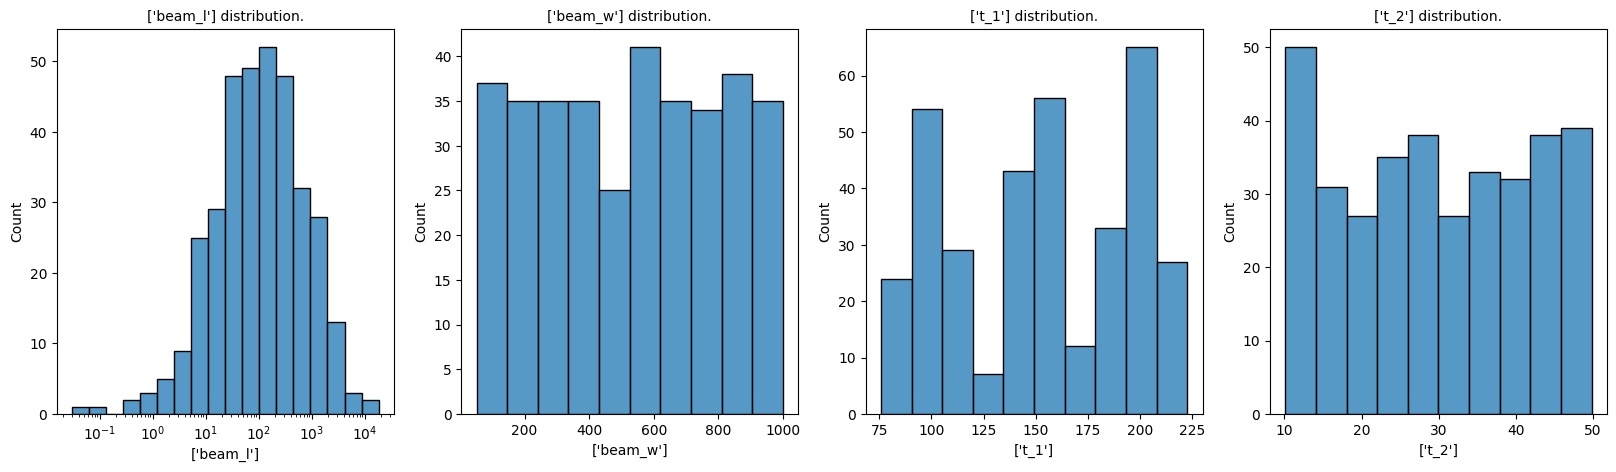

In [ ]:
plot_distribution(df, indices_to_plot=[0, 1, 2, 3], col_names=par_names, log_scale=[True, False, False, False])

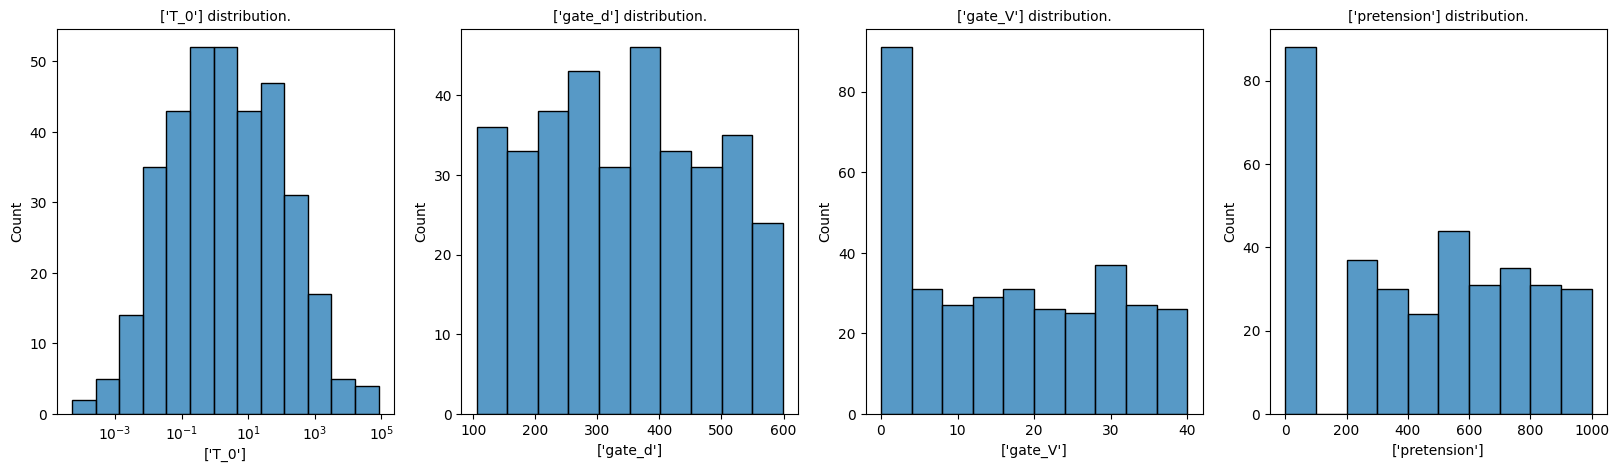

In [ ]:
plot_distribution(df, indices_to_plot=[4, 5, 6, 7], col_names=par_names, log_scale=[True, False, False, False])

Применяем ограничения на значения параметров:

In [ ]:
limits = {'beam_l': [10, 1200], 
          'T_0': [1e-2, 300]}

df = set_limits(df, limits)
print(df.shape)

(221, 8)


Визуализация результата:

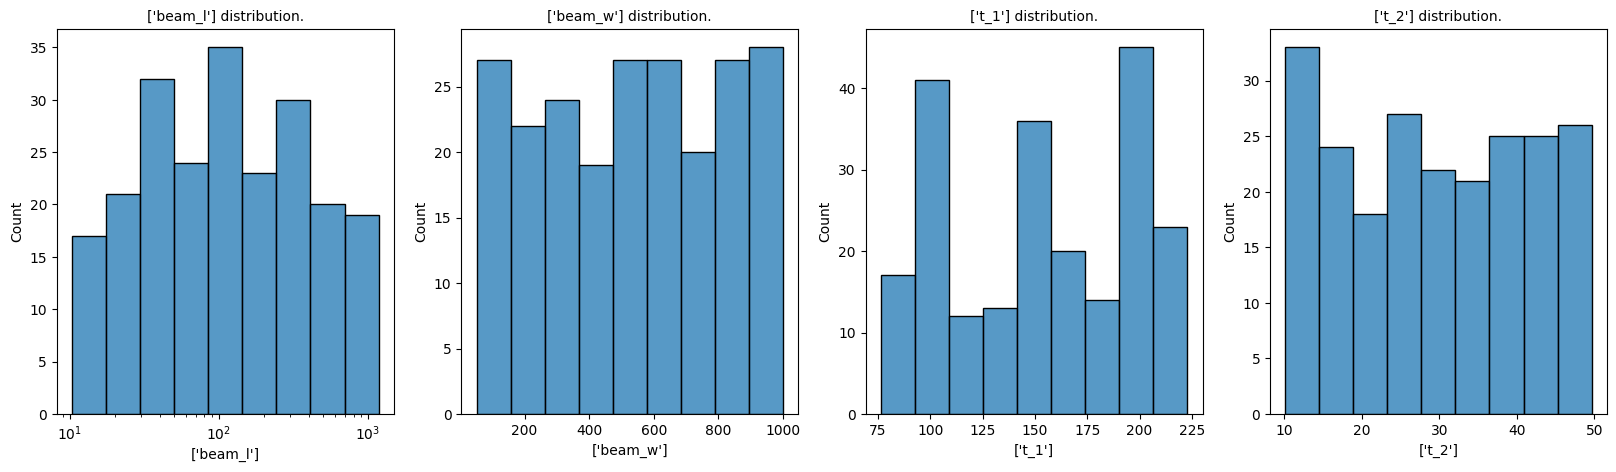

In [ ]:
plot_distribution(df, indices_to_plot=[0, 1, 2, 3], col_names=par_names, log_scale=[True, False, False, False])

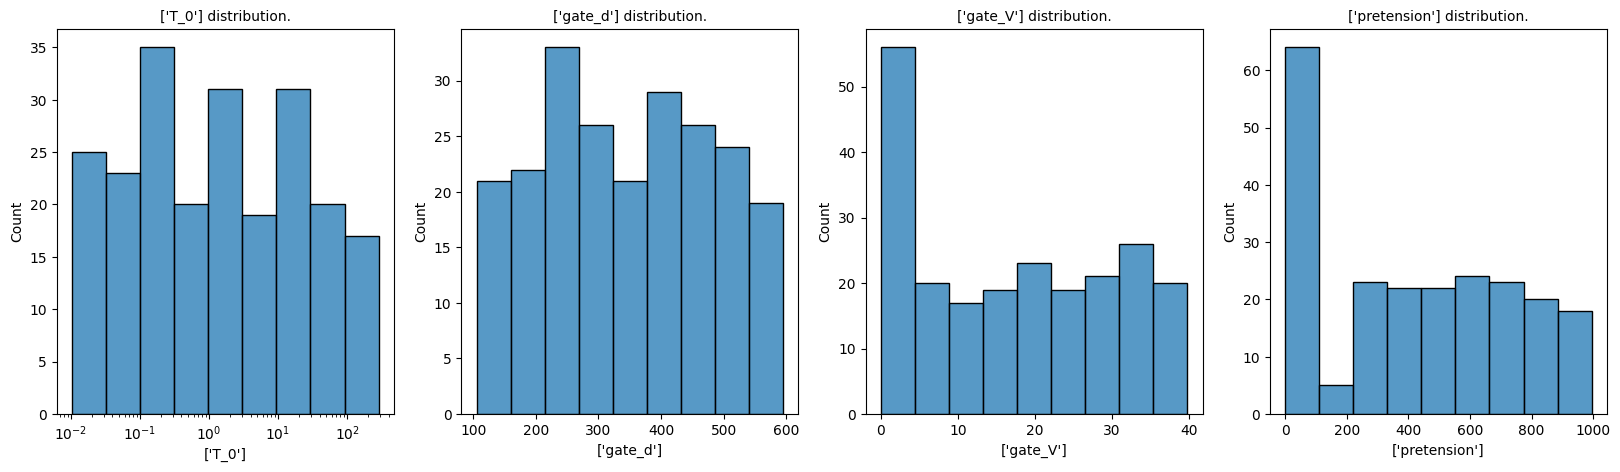

In [ ]:
plot_distribution(df, indices_to_plot=[4, 5, 6, 7], col_names=par_names, log_scale=[True, False, False, False])

Функция, которая формирует `.txt` файл для отправки в метод конечных элементов

In [ ]:
def get_txt(df, par_quantities):
    with open('FEM_input.txt', 'w') as f:
        for par_index in range(0, df.shape[1]):
            f.write(f'{list(df.columns)[par_index]} ' + '\"')
            for index in range(0, df.shape[0]):
                f.write(f'{df.iloc[index, par_index].item()}, ')
                if index == (df.shape[0] - 1):
                    f.write(f'{df.iloc[index, par_index].item()}')
            f.write('\" ' + f'{par_quantities[par_index]}')
            f.write('\n')

get_txt(df, par_quantities)

In [ ]:
pd.set_option('display.max_columns', 30)
df.describe()

,beam_l,beam_w,t_1,t_2,T_0,gate_d,gate_V,pretension
count,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,224.898368,533.873838,153.378679,29.580072,19.558352,348.694078,17.153124,415.313789
std,266.804195,283.391391,42.897036,11.955915,43.858764,135.775999,13.080453,327.596605
min,10.378022,51.573618,76.484336,10.102795,0.010465,105.356750,0.000000,0.000000
25%,41.454883,281.872415,107.948533,18.795350,0.145064,231.564876,4.391467,0.000000
50%,106.048372,542.283603,154.144726,28.891023,1.169421,362.860753,17.435232,410.302235
75%,314.624764,781.575359,196.479392,39.542524,15.414552,457.156066,28.766848,717.566973
max,1176.597066,999.300834,222.750737,49.655661,285.709042,594.508929,39.802060,994.462724
